# Heart-rate Intersubject correlation
by François Lespinasse

### Dependencies

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import pickle
import neurokit2 as nk
from scipy.stats import sem, t
import numpy as np
import systole
import pingouin as pg
from brainiak import isc
import itertools
import os
import fnmatch
os.environ['NUMEXPR_MAX_THREADS'] = '64'
os.environ['NUMEXPR_NUM_THREADS'] = '64'

/home/francois.lespinasse/anaconda3/envs/biosigEnv/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.8, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/home/francois.lespinasse/anaconda3/envs/biosigEnv/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
from statsmodels.stats.multitest import multipletests

### log specification

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
#import logging
#logging.basicConfig()
#logging.getLogger().setLevel(logging.INFO)

### Figure specifications and color palette

In [5]:
pal_pw = sns.color_palette("magma",n_colors=17, desat=.9)[2:]
pal_loo = sns.color_palette("magma",n_colors=6, desat=.9)
pal_loo.reverse()
pal_pw.reverse()
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

### Main directory and variables

In [6]:
indir = "/scratch/flesp/physio_data/friends1/viz/"
subs=['sub-01','sub-02', 'sub-03', 'sub-04','sub-05', 'sub-06']
pairs = []
for s in itertools.combinations(subs,2):
    pairs.append(f"{s[0]}_{s[1]}")
#ses=['ses-001', 'ses-002']
#task=['task-s01e01a','task-s01e01b', 'task-s01e02a', 'task-s01e02b']

### Load data
Sanity check

In [7]:
# Load metadata
fetcher=pd.read_csv('/scratch/flesp/physio_data/friends1/pilot_hr-isc.csv', index_col=0)
tasks_list = pd.Series(pd.unique(fetcher['task'].unique())).dropna().sort_values()
# Make sure we have enough subject for each task
ok_task=[]
for task in tasks_list:
    tmp = fetcher[fetcher['task']==task]
    if len(tmp)>5:
        ok_task.append(task)
print(tmp)

     ectopic  extra                                           filename  long  \
563     39.0    0.0  /scratch/flesp/physio_data/friends1/viz/sub-03...   3.0   

     mean_rr_heartpy  mean_rr_systole  missed  nb_vol  rejection_%  run_id  \
563        853.86794       853.821359     1.0   488.0          0.0     4.0   

    session_id  short  std_rr_hp  std_rr_systole subject          task  
563    ses-067    5.0   30.04271       28.840844  sub-03  task-s05e23d  


### Organize RR time series
Fetch timeseries of RR intervals for each subject and task, normalize them (z score), then resample to number of TR in run and cut the 9 seconds padding. 

In [8]:
RR={}
# iterate over tasks
for task in ok_task:
    # print(f"Processing {task}")
    # store RR data
    rr_data=pd.DataFrame(columns=subs)

    # get number of volumes for this task
    nb_vol=fetcher['nb_vol'][fetcher['task']==task].values[0]
    # iterate over subjects
    for s in subs:
        row = fetcher[(fetcher['subject']==s) & (fetcher['task']==task)]
        # do we have a single file or a list of files?
        try:
            fn = row['filename'].values[0]
            pass
        except IndexError:
            fn = row['filename']
            if isinstance(row['filename'],pd.Series):
                continue
        # load data
        with open(fn, 'rb') as f:
            tmp=pickle.load(f)
        # extract RR data
        rr=tmp['PPG_clean_rr_systole']
        # standardize and resample
        nn=nk.standardize(rr, robust=True)
        data=pd.Series(nk.signal_resample(nn, desired_length=int(nb_vol)))
        # store subject's timeserie for this task and cut first and last 6 timepoints
        rr_data[s]=data
    # store data
    RR[task]=rr_data
   

## Compute empirical ISC
Iterate through RR timeseries and cut windows of 30 timepoints, then store in a dataframe and a list

Run one of the two follwoing code blocks

In [9]:
sub=['sub-01', 'sub-02', 'sub-03', 'sub-04','sub-05', 'sub-06']
iscs=[]
coeffs = pd.DataFrame()
list_r30 = []
# iterate over tasks
for task in RR:
    # iterate over 30TRs segments
    for i, window in enumerate(range(0, len(RR[task]), 30)):
        segment=RR[task].loc[window:window+29]
        # check sanity
        if len(segment[sub].dropna()) < 30 or len(segment[sub].dropna().columns) < 6:
            continue
            
        # compute empirical ISC
        isc_r = isc.isc(segment.values, pairwise=True, summary_statistic=None)
        
        if len(isc_r) != 15:
            continue
        coeffs[f"{task}seg{i:02d}"] = isc_r.flatten()
        list_r30.extend(list(np.concatenate(isc_r).flat))
# associate to names
coeffs.index=pairs

In [10]:
len(coeffs.columns)

1179

## Half episodes

In [ ]:
sub=['sub-01', 'sub-02', 'sub-03', 'sub-04','sub-05', 'sub-06']
iscs=[]
coeffs = pd.DataFrame()
list_r = []
# iterate over tasks
for task in RR:
    # check sanity
    if len(RR[task][sub].dropna()) < 380 or len(RR[task][sub].dropna().columns) < 6:
        continue
            
    # compute empirical ISC
    isc_r = isc.isc(RR[task].values, pairwise=True, summary_statistic=None)
        
    if len(isc_r) != 15:
        continue
    coeffs[f"{task}"] = isc_r.flatten()
    list_r.extend(list(np.concatenate(isc_r).flat))
# associate to names
coeffs.index=pairs

In [ ]:
len(coeffs.columns)

## Bootstrapped data
Build a bootstrapped dataset by shuffling timeseries, using 100 iterations

In [11]:
from sklearn.utils import resample
len_of_timeseries = 30
number_of_timeseries = len(coeffs.columns)
list_of_bootstrapped_coeffs = []
for iterat in range(200):
    appended_df = pd.DataFrame()

    # iterate over tasks RR data
    for key, df in RR.items():
        # make sure we have enough timepoints
        if len(df) < 100:
            continue
        # append data in a single dataframe
        appended_df = appended_df.append(df, ignore_index=True)

    # make a list of chunks of 30 timepoints
    chunks = [appended_df.iloc[i:i+len_of_timeseries] for i in range(0, appended_df.shape[0], len_of_timeseries)]
    # bootstrap chunks
    bootstrap_index = {}
    for idx in range(6):
        # choose len(coeffs) random chunks
        resampled_chunk = resample(range(0,len(chunks)), replace=False, random_state=iterat*idx)
        # store the index of the chunks
        bootstrap_index[idx] = resampled_chunk

    # create a dictionary with the bootstrapped data
    bootstrap_dict = {}
    for key, item in bootstrap_index.items():
        bootstrap_dict[f"sub-{key+1:02d}"] = []
        # iterate over the chunks and append the resampled ones to the dictionary
        for idx, df in enumerate(chunks):
            if len(df) < len_of_timeseries:
                continue
            # one list per subject for the totality of chunks
            bootstrap_dict[f"sub-{key+1:02d}"].append(chunks[item[idx]].iloc[:,key])
    # reconcatenate the bootstrapped data
    whole_df = pd.DataFrame()
    for key in bootstrap_dict:
        sub_df = pd.concat(bootstrap_dict[key], ignore_index=True)
        whole_df[key] = sub_df
    # make a list of chunks of 30 timepoints
    bootstrapped_chunks = [whole_df.iloc[i:i+len_of_timeseries] for i in range(0, whole_df.shape[0], len_of_timeseries)]
    
    # compute ISC for each chunk
    bootstrap_coeffs = pd.DataFrame()
    for idx, item in enumerate(bootstrapped_chunks[:number_of_timeseries]):
        isc_r = isc.isc(item.values, pairwise=True, summary_statistic=None)
        bootstrap_coeffs[f"{idx}"] = isc_r.flatten()
    # append the bootstrapped ISC coeffs to a list of df
    list_of_bootstrapped_coeffs.append(bootstrap_coeffs)

### Storing bootstrapped coeffs
Compute the mean across all observations, and concatenate all bootstrapped coeffs of all pairs

In [12]:
# make a dictionary of sub names
comb = {}
for s in subs:
    comb[s] = (fnmatch.filter(coeffs.index, f"*{s}*"))

In [13]:
average_of_boot = []
for bootsy in list_of_bootstrapped_coeffs:
    average_of_boot.append(np.tanh(np.nanmean(np.arctanh(bootsy.values), axis=None)))

sub_average_of_boot = {}
for s in subs:
    sub_average_of_boot[s] = []
    for boots in list_of_bootstrapped_coeffs:
        boots.index=pairs
        sub_average_of_boot[s].append(np.tanh(np.nanmean(np.arctanh(boots.T[comb[s]].values), axis=None)))

pair_average_of_boot = {}
for pair in pairs:
    pair_average_of_boot[pair] = []
    for boots in list_of_bootstrapped_coeffs:
        boots.index = pairs
        pair_average_of_boot[pair].append(np.tanh(np.nanmean(np.arctanh(boots.T[pair].values), axis=None)))

In [14]:
pair_concat = {}
for idx, pair in enumerate(pairs):
    pair_df_iterat = pd.DataFrame()
    pair_concat[pair] = []
    for i, bootsy in enumerate(list_of_bootstrapped_coeffs):
        bootsy.index=pairs
        pair_concat[pair].append(bootsy.T[pair])
    pair_concat[pair] = pd.concat(pair_concat[pair], ignore_index=True)

## Group mean hypothesis testing
Check significance of the empirical mean against the bootstrapped
Compute confidence intervals for each and plot them

In [15]:
pvals = []
value = np.arctanh(np.nanmean(np.tanh(coeffs.values), axis=None))
p = np.sum(value <= average_of_boot)/len(average_of_boot)
pvals.append(p)
reject, pvals_corrected, _, _ = multipletests(pvals, method='fdr_bh')
print(reject, pvals_corrected)

[ True] [0.005]


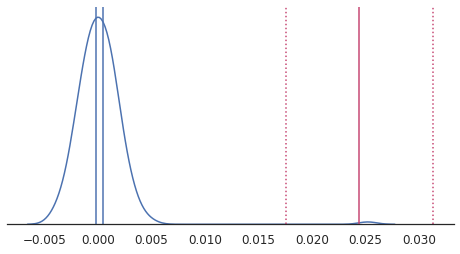

In [16]:
plt.figure(figsize=(8,4))
sem_boot = t.interval(0.95, len(average_of_boot)-1, loc=np.tanh(np.nanmean(np.arctanh(average_of_boot))), scale=sem(average_of_boot))
sem_empirical = t.interval(0.95, len(coeffs.values)-1, loc=np.tanh(np.mean(np.arctanh(coeffs.values))), scale=sem(np.mean(coeffs.values, axis=1)))
ax = sns.kdeplot(average_of_boot)
#sns.kdeplot(coeffs.values.flatten(), color=pal_loo[2])
ax.axvline(np.tanh(np.mean(np.arctanh(coeffs.values))), color=pal_pw[-8])
ax.axvline(sem_boot[0])
ax.axvline(sem_boot[1])
ax.axvline(sem_empirical[0], linestyle=':', color=pal_pw[-8])
ax.axvline(sem_empirical[1],  linestyle=':', color=pal_pw[-8])
ax.set(title="")
ax.set(xlabel="",yticks=[], ylabel="")
plt.xticks(fontsize=12)
sns.despine(left=True)
plt.savefig("realaverage_against_bootstrappedmeans.png", dpi=300)

## Subject-level Hypothesis tests
Semi-parametric test against bootstrapped average coefficient across pairs involving a given subject in each segments ; visualize using uncorrected significance threshold alpha=0.2.

In [17]:

# average r values for each task for all pairs involving a given sub
av_r = {}
for task in coeffs.columns:
    list_s = []
    list_boot_s = []
    for s in comb:
        # Fischer's z transformation applied to r values of a given sub, arctanh, mean, then inverse (tanh)
        list_s.append(np.tanh(np.mean(np.arctanh(coeffs[task][comb[s]]))))
    av_r[task] = list_s
    
# store in a dataframe n_subs x n_tasks
mean_hr_coeffs = pd.DataFrame(av_r)
mean_hr_coeffs.index = subs

In [18]:
pvals = []
for s in subs:
    value = np.arctanh(np.mean(np.tanh(mean_hr_coeffs.T[s]), axis=None))
    p = np.sum(value <= sub_average_of_boot[s])/len(sub_average_of_boot[s])
    pvals.append(p)
reject, pvals_corrected, _, _ = multipletests(pvals, method='fdr_bh')
significance_sub_mean = pd.DataFrame([reject, pvals_corrected], columns=subs)
significance_sub_mean

,sub-01,sub-02,sub-03,sub-04,sub-05,sub-06
0,True,True,True,True,True,True
1,0.005,0.005,0.0,0.005,0.005,0.005


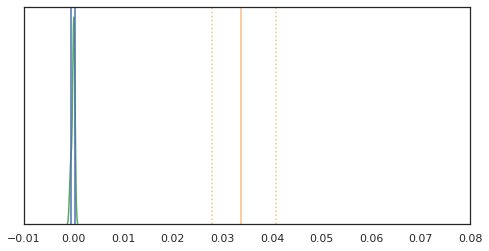

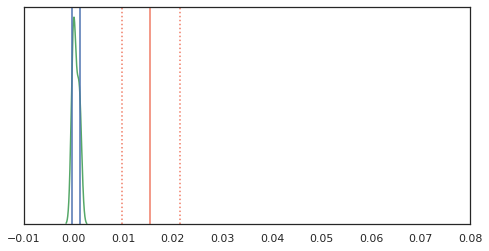

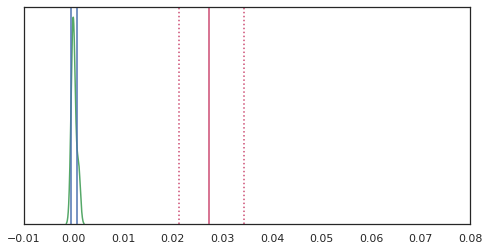

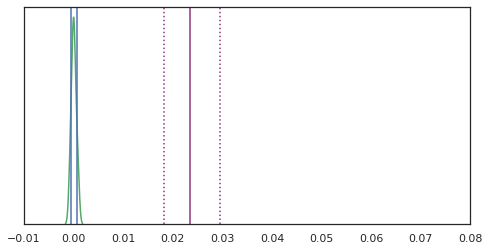

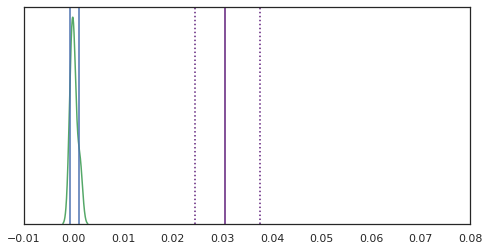

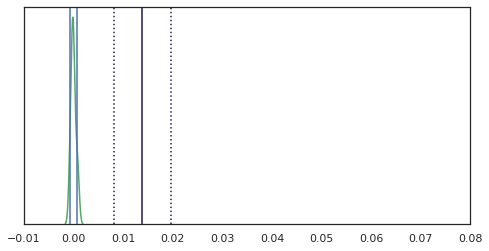

In [19]:
significance_mean = {}
for idx, s in enumerate(subs):
    plt.figure(figsize=(8,4))
    # standard error
    sem_boot = t.interval(0.95,
                          len(pd.DataFrame(pair_concat)[comb[s]].mean())-1,
                          loc=np.tanh(np.nanmean(np.arctanh(pd.DataFrame(pair_concat)[comb[s]].mean()))), 
                          scale=sem(pd.DataFrame(pair_concat)[comb[s]].mean()))
    
    sem_empirical = t.interval(0.95,
                               len(mean_hr_coeffs.T[s].values)-1,
                               loc=np.tanh(np.nanmean(np.arctanh(mean_hr_coeffs.T[s].values))),
                               scale=sem(mean_hr_coeffs.T[s].values))
    if significance_sub_mean[s][0]:
        color='g'
    else:
        color='r'
    ax = sns.kdeplot(pd.DataFrame(pair_concat)[comb[s]].mean(), color=color)
    ax.axvline(mean_hr_coeffs.T[s].mean(), color=pal_loo[idx])
    ax.axvline(sem_boot[0])
    ax.axvline(sem_boot[1])
    ax.axvline(sem_empirical[0], linestyle=':', color=pal_loo[idx])
    ax.axvline(sem_empirical[1],  linestyle=':', color=pal_loo[idx])
    ax.set(xlim=(-0.01, 0.08 ))
    ax.set(xlabel="",yticks=[], ylabel="")
    #sns.despine(left=True)
    plt.show()
    #plt.savefig(f"{s}_HR-ISC_mean-hypothesistesting.png", dpi=300)
    plt.close('all')

### Visualize
plotting distribution for each subject using mean values across pairs involving a given subject for all segments

In [20]:
from scipy.stats import ttest_rel
from scipy.stats import percentileofscore

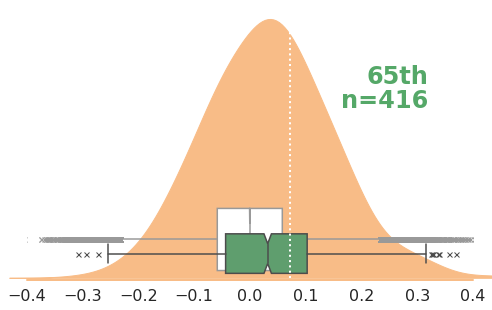

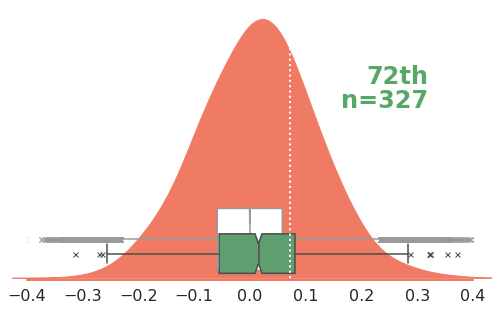

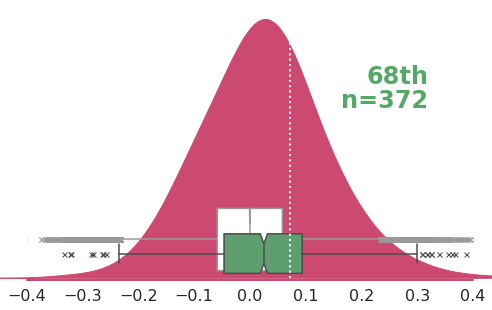

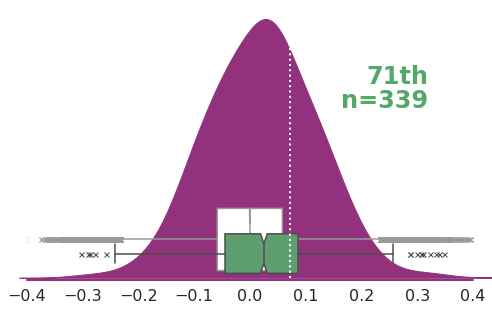

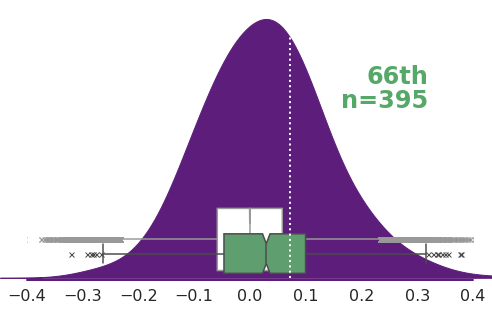

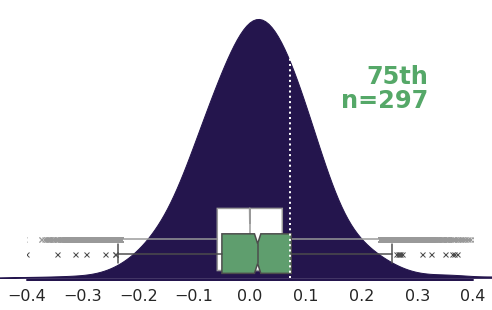

In [21]:
for idx in range(len(subs)):
    plt.figure(figsize=(8,5))
    data_boot = np.tanh(np.nanmean(np.arctanh(pd.DataFrame(pair_concat)[comb[s]]), axis=1))
    data_emp = mean_hr_coeffs.T[subs[idx]]
    # bw_adjust=.8, 
    ax = sns.kdeplot(x=data_emp,
                     clip_on=False,
                     fill=True, alpha=1, linewidth=1.,bw_adjust=1.5,
                     color=pal_loo[idx])
    ax2 = ax.twinx()
    sns.boxplot(x=data_boot,notch=True, showcaps=False,
                dodge=True,flierprops={"marker": "x"},
                ax=ax2,orient='h', color='white')
    ax.set(xlim=(-0.4,0.4))
    #ax.set(ylim=(0,4.3))
    if significance_sub_mean[s][0]:
        color_sig='g'
    else:
        color_sig='r'
    for label in ax.get_xticklabels():
        label.set_fontsize(16)
        
    percentile_80 = np.tanh(np.nanquantile(np.arctanh(pd.DataFrame(data_boot)), 0.80))
    
    ax1 = ax.twinx()
    sns.boxplot(data_emp, ax=ax1,orient='h',notch=True,
                flierprops={"marker": "x"}, color=color_sig)
    ax1.set(ylim=(-0.5,5))
    ax1.set(yticks=[])
    

    
    def label(x, color, label):
        text = f"{round(percentileofscore(data_emp, percentile_80))}th"
            
        ax = plt.gca()
        ax.text(.9, .7, f'{text}', fontsize=24, fontweight="bold", color=color_sig,
                ha="right", va="bottom", transform=ax.transAxes)
        ax.text(.9, .61, f'n={len(data_emp.loc[data_emp > percentile_80])}',
                fontsize=24, fontweight="bold", color=color_sig,
                ha="right", va="bottom", transform=ax.transAxes)
        ax.axvline(percentile_80, linestyle=':', linewidth=2.0,color='white')
        
    label(data_emp, label=subs[idx], color=pal_loo[idx])
    
    ax.set(title="")
    ax.set(xlabel="",yticks=[], ylabel="")
    ax2.set(ylim=(-0.5, 3))
    ax2.set(xlabel="",yticks=[], ylabel="")
    sns.despine(left=True, bottom=True)
    
    plt.axhline(y=-.53, linewidth=2, linestyle="-", color=pal_loo[idx], clip_on=False)
    
    #plt.savefig(f"{subs[idx]}_HR-ISC_dist.png", dpi=300)
    plt.show()
    plt.close('all')

## Pair-level hypothesis testing
### Testing mean

In [22]:
pvals = []
for pair in pairs:
    value = np.arctanh(np.mean(np.tanh(coeffs.T[pair]), axis=None))
    p = np.sum(value <= pair_average_of_boot[pair])/len(pair_average_of_boot[pair])
    pvals.append(p)
reject, pvals_corrected, _, _ = multipletests(pvals, method='fdr_bh')
significance_pair_mean = pd.DataFrame([reject, pvals_corrected], columns=pairs)

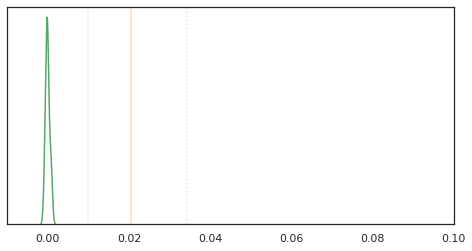

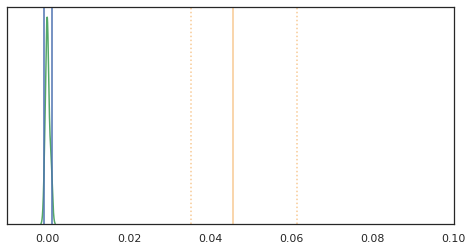

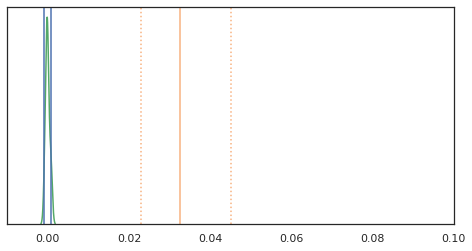

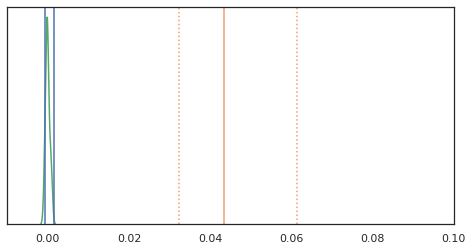

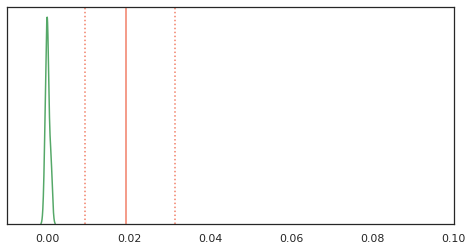

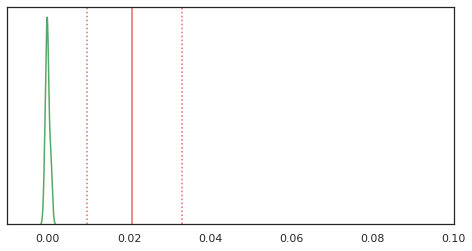

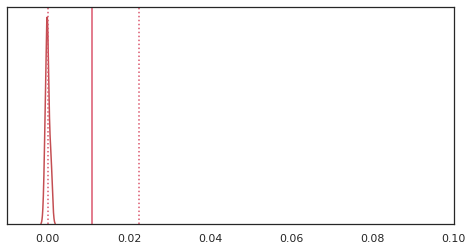

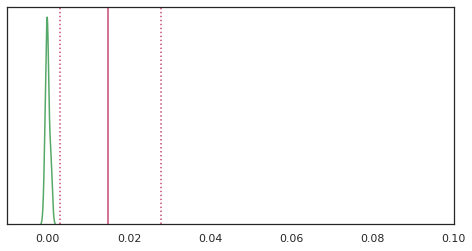

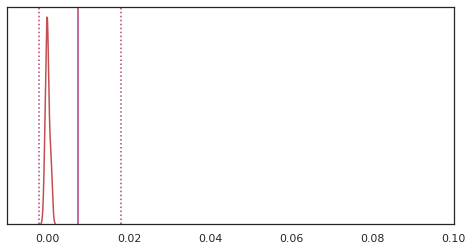

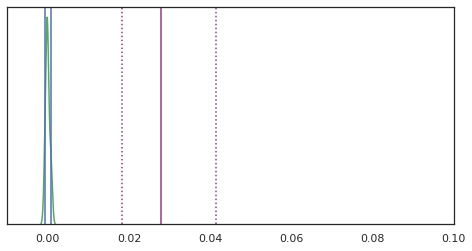

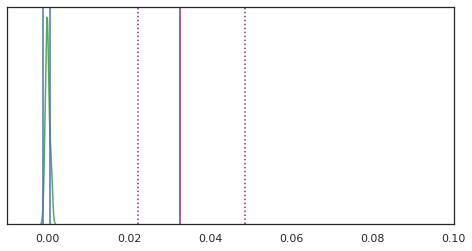

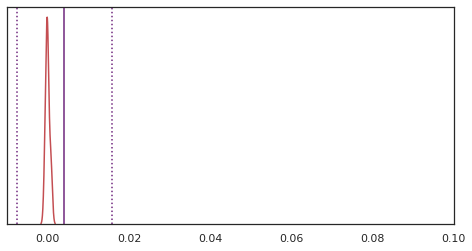

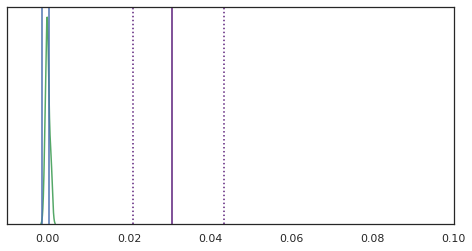

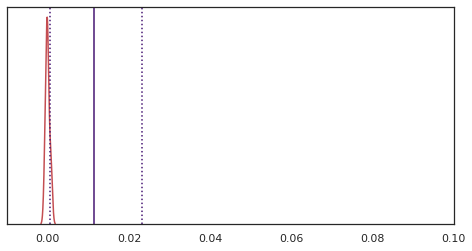

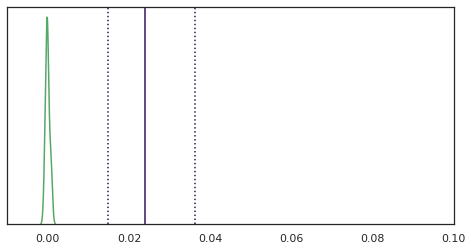

In [23]:
for idx, pair in enumerate(pairs):
    plt.figure(figsize=(8,4))
    sem_boot = t.interval(0.95, len(pd.DataFrame(pair_concat)[pair])-1, loc=np.tanh(np.nanmean(np.arctanh(pd.DataFrame(pair_concat)[pair]))), scale=sem(pd.DataFrame(pair_concat)[pair]))
    sem_empirical = t.interval(0.95, len(coeffs.T[pair].values)-1, loc=np.tanh(np.nanmean(np.arctanh(coeffs.T[pair].values))), scale=sem(coeffs.T[pair].values))
    if significance_pair_mean[pair][0]:
        color='g'
    else:
        color='r'
    ax = sns.kdeplot(pd.DataFrame(pair_concat)[comb[s]].mean(), color=color)
    #sns.histplot(coeffs.T[pair].values, color=pal_pw[idx], ax=ax)
    ax.axvline(coeffs.T[pair].mean(), color=pal_pw[idx])
    ax.axvline(sem_boot[0])
    ax.axvline(sem_boot[1])
    ax.axvline(sem_empirical[0], linestyle=':', color=pal_pw[idx])
    ax.axvline(sem_empirical[1],  linestyle=':', color=pal_pw[idx])
    #ax.set(title=f"{pair}")
    ax.set(xlim=(-0.01, 0.1 ))
    ax.set(xlabel="",yticks=[], ylabel="")
    #sns.despine(left=True)
    plt.show()
    #plt.savefig(f"{pair}_HR-ISC_mean_hypothesistesting.png",dpi=300)
    plt.close('all')

### Testing segments

In [27]:

p_val_dict = {}
for idx in range(len(pairs)):
    pvals = []
    # concatenate all the bootstrap values for a given pair
    bootstrapped_pair_coeff = pair_concat[pairs[idx]]
    for value in coeffs.T[pairs[idx]].values:
        p = np.sum(value <= bootstrapped_pair_coeff)/len(bootstrapped_pair_coeff)
        pvals.append(p)
    p_val_dict[idx] = pvals
for idx in range(len(pairs)):
    pvals_fdr = p_val_dict[idx]
    reject, pvals_corrected, _, _ = multipletests(pvals_fdr, method='fdr_bh')
    print(pairs[idx], len(pvals_corrected[pvals_corrected < 0.2]))

sub-01_sub-02 4
sub-01_sub-03 0
sub-01_sub-04 0
sub-01_sub-05 0
sub-01_sub-06 0
sub-02_sub-03 0
sub-02_sub-04 0
sub-02_sub-05 0
sub-02_sub-06 0
sub-03_sub-04 3
sub-03_sub-05 6
sub-03_sub-06 0
sub-04_sub-05 1
sub-04_sub-06 2
sub-05_sub-06 6


sub-01_sub-02


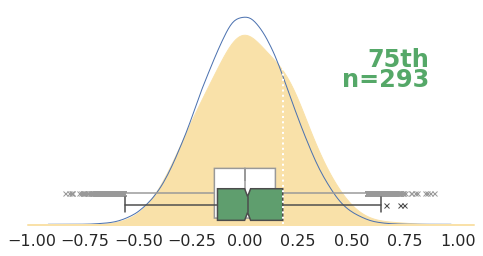

sub-01_sub-03


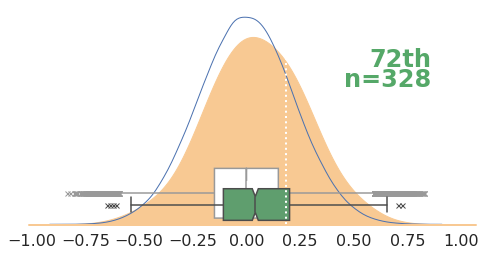

sub-01_sub-04


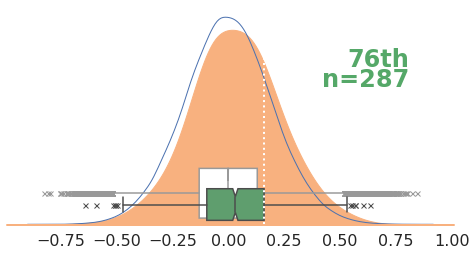

sub-01_sub-05


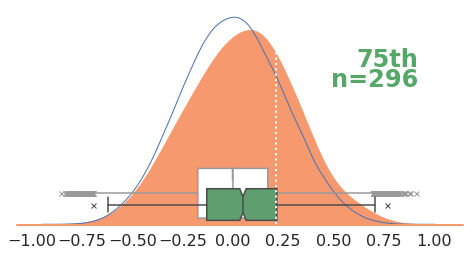

sub-01_sub-06


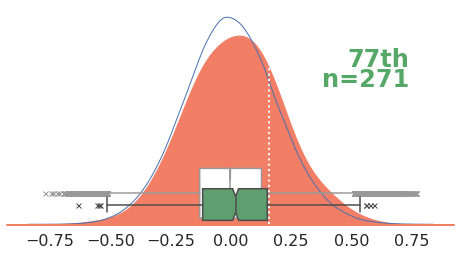

sub-02_sub-03


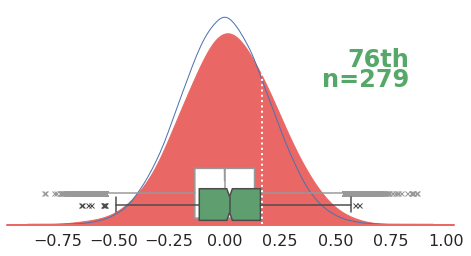

sub-02_sub-04


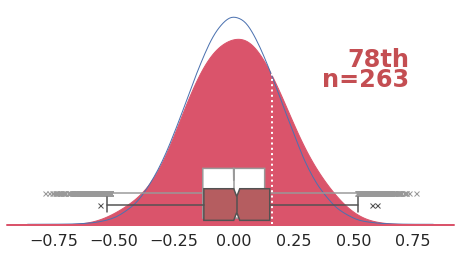

sub-02_sub-05


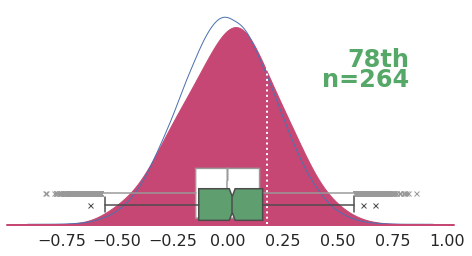

sub-02_sub-06


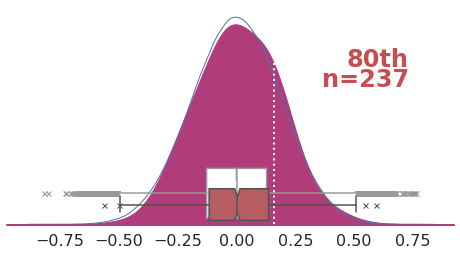

sub-03_sub-04


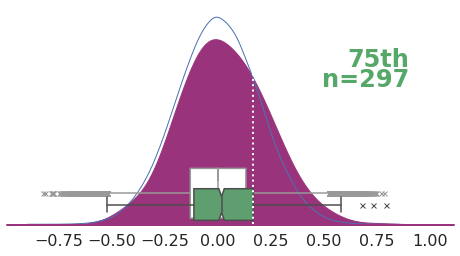

sub-03_sub-05


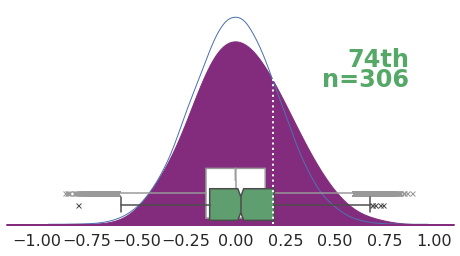

sub-03_sub-06


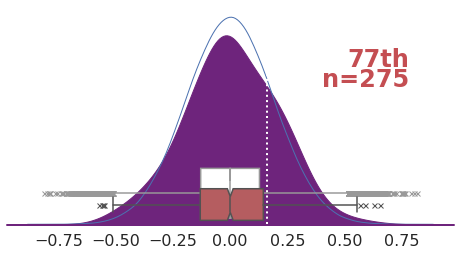

sub-04_sub-05


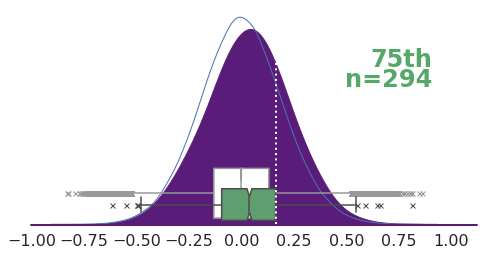

sub-04_sub-06


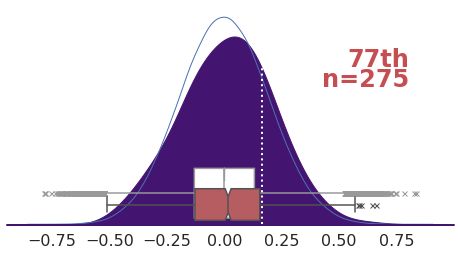

sub-05_sub-06


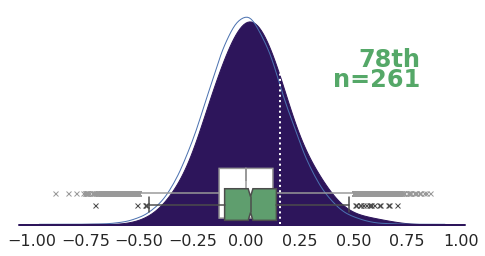

In [28]:
for idx in range(len(pairs)):
    plt.figure(figsize=(8,4))
    print(pairs[idx])
    data_emp = coeffs.T[pairs[idx]]
    data_boot = pd.DataFrame(pair_concat)[pairs[idx]]
    # bw_adjust=.8, 
    ax = sns.kdeplot(x=data_emp,clip_on=False,
                     fill=True, alpha=1, linewidth=1.,bw_adjust=1.5,color=pal_pw[idx])
    if significance_pair_mean[pairs[idx]][0]:
        color_sig='g'
    else:
        color_sig='r'
    percentile_80=np.tanh(np.nanquantile(np.arctanh(data_boot), 0.80))
        
    ax2 = ax.twinx()
    sns.kdeplot(data_boot,clip_on=False,
                fill=False, alpha=1, linewidth=1.,bw_adjust=1.5, ax=ax)
    sns.boxplot(x=data_boot,notch=True, showcaps=False,
                dodge=True,flierprops={"marker": "x"},
                ax=ax2,orient='h', color='white')
    ax1 = ax.twinx()
    sns.boxplot(data_emp, ax=ax1,orient='h',notch=True,
                flierprops={"marker": "x"}, color=color_sig)

    for label in ax.get_xticklabels():
        label.set_fontsize(16)    

    
    def label(x, color, label):
        text = f"{round(percentileofscore(data_emp, percentile_80,))}th"
            
        ax = plt.gca()
        ax.text(.9, .7, f'{text}', fontsize=24, fontweight="bold", color=color_sig,
                ha="right", va="bottom", transform=ax.transAxes)
        ax.text(.9, .61, f'n={len(x.loc[x > percentile_80])}',
                fontsize=24, fontweight="bold", color=color_sig,
                ha="right", va="bottom", transform=ax.transAxes)
        ax.axvline(percentile_80, linestyle=':', linewidth=2.0,color='white')
        
    label(data_emp, label=pairs[idx], color=pal_pw[idx])
    
    ax.set(title="")
    ax.set(xlabel="",yticks=[], ylabel="")
    ax2.set(ylim=(-0.5, 3))
    ax2.set(xlabel="",yticks=[], ylabel="")
    sns.despine(left=True, bottom=True)
    #ax.set(xlim=(-.5,.5))
    #ax.set(ylim=(0,2))
    ax1.set(ylim=(-0.5,5))
    ax1.set(yticks=[])
    plt.axhline(y=-.53, linewidth=2, linestyle="-", color=pal_pw[idx], clip_on=False)
    
    #plt.savefig(f"{pairs[idx]}_HR-ISC_dist.png", dpi=300)
    plt.show()
    #plt.close('all')